In [0]:
import    os
import    matplotlib.pyplot      as plt
import    cv2                    as cv
import    numpy                  as np
import    pandas                 as pd

from   sklearn.cluster           import  KMeans
from   skimage.feature           import  hog
from   sklearn.decomposition     import  PCA
from   tqdm                      import  tqdm

from   sklearn.ensemble          import  RandomForestClassifier
from   sklearn.cluster           import  KMeans
from   sklearn.model_selection   import  cross_val_score
from   sklearn.model_selection   import  KFold
from   sklearn.metrics           import  *
from   sklearn.model_selection   import  GridSearchCV
from   sklearn.mixture           import  GaussianMixture

In [0]:
pathImgTraining     =      '/content/drive/My Drive/DataSet/training/img/'
pathLblTraining     =      '/content/drive/My Drive/DataSet/training/labels/'
pathImgTest         =      '/content/drive/My Drive/DataSet/test/img/'
pathLblTest         =      '/content/drive/My Drive/DataSet/test/labels/'
pathUniverse        =       '/content/drive/My Drive/DataSet/universe/'

parchSize           =      100
parcheDes           =      100

In [0]:
def blur(img):
  
  dst = cv.GaussianBlur(img,(9,9),0)
  
  return dst

In [0]:
imagenesTraining    =   os.listdir(pathImgTraining)
imagenesTest        =   os.listdir(pathImgTest)
universe            =   os.listdir(pathUniverse)

print('Imagenes de training:',len(imagenesTraining), '; Imagenes de test:',len(imagenesTest))
print('Imagenes del universo:',len(universe))

Imagenes de training: 9 ; Imagenes de test: 3
Imagenes del universo: 84


In [0]:
def parchar(img, tam, paso):
  
  import numpy as np
  
  parches  = []
  dim      = np.shape(img)
  yInicial = 0
  yFinal   = tam
  totalY   = 0
  
  while yFinal <= dim[0]:
    
    xInicial = 0
    xFinal   = tam  
    totalX   = 0
    
    while xFinal <= dim[1]:
      
      parches.append(img[yInicial:yFinal, xInicial:xFinal])
      #print(xInicial, xFinal, yInicial, yFinal)
      
      xInicial +=  paso
      xFinal   +=  paso
      totalX   += 1
    
    yInicial +=  paso
    yFinal   +=  paso
    totalY   +=  1
      
  return parches, totalY,totalX

Total de parches: 300
Total de parches: 300
Tamaño del parche: (300, 100, 100, 3)
Dimensiones y, x: 15 20


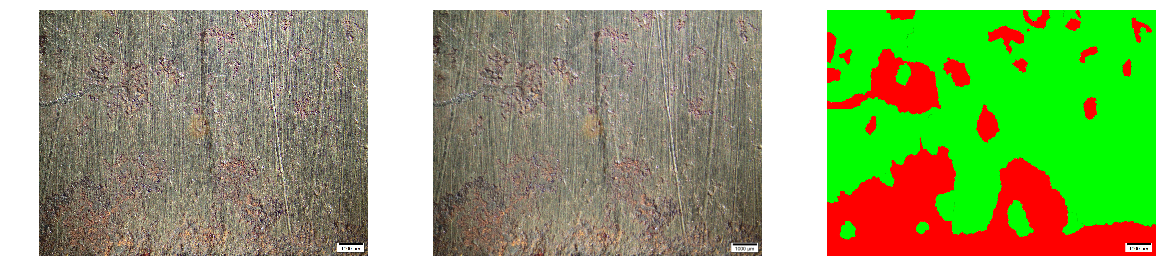

In [0]:
imagenPrueba        = cv.cvtColor(cv.imread(pathImgTest + imagenesTest[2]), cv.COLOR_BGR2RGB)
lblPrueba           = cv.cvtColor(cv.imread(pathLblTest + imagenesTest[2][:-4] + '.png'), cv.COLOR_BGR2RGB) 
imagenPruebaBlur    = blur(cv.cvtColor(cv.imread(pathImgTest + imagenesTest[2]), cv.COLOR_BGR2RGB))
parchesPrueba, a, b = parchar(imagenPruebaBlur, parchSize, parcheDes)
labelsPrueba, a, b  = parchar(lblPrueba, parchSize, parcheDes)

print('Total de parches:', len(parchesPrueba))
print('Total de parches:', len(labelsPrueba))
print('Tamaño del parche:', np.shape(parchesPrueba))
print('Dimensiones y, x:',a, b)

plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(imagenPrueba)

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(imagenPruebaBlur)

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(lblPrueba)

In [0]:
def clasificar(parches, etiquetas, tam):
  
  rojos  = []
  verdes = []
  
  for i, etiqueta in enumerate(etiquetas):
    #print(np.sum(etiqueta[:,:,0] == 255) == tam*tam, np.sum(etiqueta[:,:,1] == 255) == tam*tam)
    if np.sum(etiqueta[:,:,0] == 255) == tam*tam:
      
      rojos.append(parches[i])
      
    if np.sum(etiqueta[:,:,1] == 255) == tam*tam:
      
      verdes.append(parches[i])
      
  return rojos,verdes
      
      

In [0]:
entrenamientoKmeans = []

for i in tqdm(range(len(universe))):
  
  imagenN  = universe[i] 
  img = blur(cv.cvtColor(cv.imread(pathUniverse + imagenN), cv.COLOR_BGR2RGB))
  
  parches, a, b = parchar(img, parchSize, 50)
  #print(len(parchesImagen), len(parchesLabels))
  #print(len(rojos), len(verdes))
  for parche in parches:
    
    fd = hog(cv.cvtColor(parche, cv.COLOR_RGB2GRAY), orientations=5, pixels_per_cell=(10, 10),
                            cells_per_block=(1, 1), block_norm="L2-Hys", visualize=False, multichannel=False)
    
    entrenamientoKmeans.append(fd)
    
 
   
  #print(imagenN,len(rojos), len(verdes))
  #print(len(parchesImagen), len(parchesLabels))
print(np.shape(entrenamientoKmeans))

100%|██████████| 84/84 [06:43<00:00,  4.95s/it]


(95004, 500)


In [0]:
v_words = 75

modeloK = GaussianMixture(v_words)
modeloK.fit(entrenamientoKmeans)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=75, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [0]:
prueba = np.array(entrenamientoKmeans[0])
prueba = prueba.reshape(1,-1)
print(modeloK.predict(prueba))

[48]


In [0]:
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(v_words)
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

In [0]:
xTrain = []
yTrain = []


for imagenN in imagenesTraining:
  
  img = blur(cv.cvtColor(cv.imread(pathImgTraining + imagenN), cv.COLOR_BGR2RGB))
  lbl = cv.cvtColor(cv.imread(pathLblTraining + imagenN[:-4] + '.png'), cv.COLOR_BGR2RGB)
  
  parchesImagen, a, b = parchar(img, parchSize, parcheDes)
  parchesLabels, a, b = parchar(lbl, parchSize, parcheDes)
  
  rojos, verdes = clasificar(parchesImagen, parchesLabels,parchSize)
  
  for rojo in rojos:
    
    fd = hog(cv.cvtColor(rojo, cv.COLOR_RGB2GRAY), orientations=5, pixels_per_cell=(10, 10),
                            cells_per_block=(1, 1), block_norm="L2-Hys", visualize=False, multichannel=False)
    
    histograma = build_histogram(fd.reshape(1,-1), modeloK)
    xTrain.append(histograma)
    yTrain.append(0)
    
  for verde in verdes:
    
    fd = hog(cv.cvtColor(verde, cv.COLOR_RGB2GRAY), orientations=5, pixels_per_cell=(10, 10),
                            cells_per_block=(1, 1), block_norm="L2-Hys", visualize=False, multichannel=False)
    
    histograma = build_histogram(fd.reshape(1,-1), modeloK)
    xTrain.append(histograma)
    yTrain.append(1)
  
  
print(np.shape(xTrain), np.shape(yTrain))  

(1075, 75) (1075,)


In [0]:
xTest = []
yTest = []


for imagenN in imagenesTest:
  
  img = blur(cv.cvtColor(cv.imread(pathImgTest + imagenN), cv.COLOR_BGR2RGB))
  lbl = cv.cvtColor(cv.imread(pathLblTest + imagenN[:-4] + '.png'), cv.COLOR_BGR2RGB)
  
  parchesImagen, a, b = parchar(img, parchSize, parcheDes)
  parchesLabels, a, b = parchar(lbl, parchSize, parcheDes)
  
  rojos, verdes = clasificar(parchesImagen, parchesLabels, parchSize)
  
  for rojo in rojos:
    
    fd = hog(cv.cvtColor(rojo, cv.COLOR_RGB2GRAY), orientations=5, pixels_per_cell=(10, 10),
                            cells_per_block=(1, 1), block_norm="L2-Hys", visualize=False, multichannel=False)
    
    histograma = build_histogram(fd.reshape(1,-1), modeloK)
    xTest.append(histograma)
    yTest.append(0)
    
  for verde in verdes:
    
    fd = hog(cv.cvtColor(verde, cv.COLOR_RGB2GRAY), orientations=5, pixels_per_cell=(10, 10),
                            cells_per_block=(1, 1), block_norm="L2-Hys", visualize=False, multichannel=False)
    
    histograma = build_histogram(fd.reshape(1,-1), modeloK)
    xTest.append(histograma)
    yTest.append(1)
  
  
print(np.shape(xTest), np.shape(yTest)) 

(406, 75) (406,)


In [0]:
modelo = RandomForestClassifier(criterion = 'entropy', max_depth = 73, n_estimators = 70)
s = cross_val_score(modelo, xTrain, yTrain, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.814 (+/- 0.02721)


In [0]:
modelo.fit(xTrain,yTrain)
print('Test:',modelo.score(xTest,yTest))

Test: 0.7068965517241379


In [0]:
def show_curve(est, X, y):
    means, stds = [], []
    nfolds_range = range(2,11)
    for nfolds in nfolds_range:
        #print(nfolds)
        s = cross_val_score(est, X, y, cv=KFold(nfolds, shuffle=True), scoring=make_scorer(accuracy_score))
        means.append(np.mean(s))
        stds.append(np.std(s))

    means = np.r_[means]
    stds  = np.r_[stds]
    
    plt.figure(figsize=(8,5))
    plt.plot(nfolds_range, means, label="mean", color="black")
    plt.fill_between(nfolds_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
    plt.xlabel("n folds")
    plt.ylabel("performance")
    plt.legend()

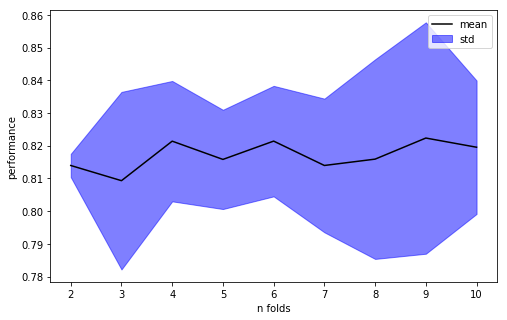

In [0]:
modelo = RandomForestClassifier(criterion = 'entropy', max_depth = 73, n_estimators = 70)
show_curve(modelo, xTrain, yTrain)

In [0]:
def reconstruir(img, modeloC, clusters):
  
  parches, totalY, totalX = parchar(img,100,10)
  mapa = np.zeros((totalY, totalX, 3))
  datos  = []
  indice = 0
  
  for i in tqdm(range(len(parches))):
    
    fd = hog(cv.cvtColor(parches[i], cv.COLOR_RGB2GRAY), orientations=5, pixels_per_cell=(10, 10),
                            cells_per_block=(1, 1), block_norm="L2-Hys", visualize=False, multichannel=False)
    
    histograma = build_histogram(fd.reshape(1,-1), clusters)
    datos.append(histograma)
  
    
  clases = modeloC.predict(datos)
  
  for y in range(totalY):
    
    for x in range(totalX):
      
      if clases[indice] == 0:
        
        mapa[y,x] = [255,0,0]
      
      else:
        
        mapa[y,x] = [0,255,0]
        
      indice += 1
      
  return mapa
  
  
mapa = reconstruir(imagenPruebaBlur, modelo, modeloK) 

100%|██████████| 28080/28080 [14:56<00:00, 31.34it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


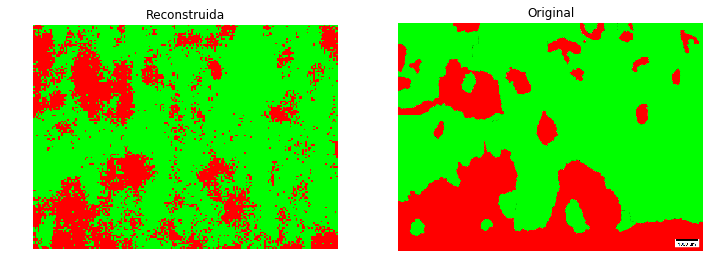

In [0]:
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.axis('off') 
plt.title('Reconstruida')
plt.imshow(mapa)

plt.subplot(1,2,2)
plt.axis('off') 
plt.title('Original')
plt.imshow(lblPrueba)